In [430]:
from __future__ import division

import pickle
import math

import numpy as np
from scipy.special import digamma, gammaln


def get_preprocessed_data(m=100):
    with open('normalized_tokenized_data.pkl', 'rb') as f:
        documents = pickle.load(f)[:m]
    vocabulary = set()
    for datum in documents:
        vocabulary.update(datum)
    vocabulary = list(vocabulary)
    return documents, vocabulary


def doc_to_match_given_vocabulary(doc, word):
    return (np.array(doc) == word).astype(int)


def initialization(documents, K, M, V, alpha_init=1.0, beta_init=0, dtype=np.float32):
    alpha = np.repeat(alpha_init, K) * 50 / K
    beta = np.full([K, V], beta_init, dtype=dtype)
    for k in range(0, K):
        unnormalized_probability = np.random.uniform(0, 1, V)
        beta[k, :] = unnormalized_probability / np.sum(unnormalized_probability)
    gamma = np.full([M, K], 0, dtype=dtype)
    phi = []
    for m, doc in enumerate(documents):
        gamma[m, :] = alpha + len(doc) / K
        phi += [np.full([len(doc), K], 1 / K)]
    return alpha, beta, phi, gamma


def E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("E-Step")
    for m, doc in enumerate(documents):
        converge = False
        converge_iteration = 0
        while not converge:
            phi_old = np.array(phi[m], copy=True)
            gamma_old = np.array(gamma[m], copy=True)
            for n in range(len(doc)):
                for i in range(K):
                    word_idx = vocabulary.index(doc[n])
                    phi[m][n][i] = beta[i, word_idx] * math.exp(digamma(gamma[m, i]) - digamma(np.sum(gamma[m, :])))
                if np.sum(phi[m][n]) == 0:
                    print("beta: {0} | digamma: {1} | digamma_sum: {2} | word: {3}".format(beta[i, word_idx],
                                                                               digamma(gamma[m, i]),
                                                                               digamma(np.sum(gamma[m])),
                                                                                vocabulary[word_idx]))
                phi[m][n] = phi[m][n] / np.sum(phi[m][n])  # Normalization
            gamma[m] = alpha + np.sum(phi[m], axis=0)
            phi_error = np.linalg.norm(phi_old - phi[m])
            gamma_error = np.linalg.norm(gamma_old - gamma[m])
            if phi_error < 1e-3 and gamma_error < 1e-3:
                converge = True
                print("Document: {0} | Iteration: {1} | "
                      "Phi_err: {2} | Gamma_err: {3}".format(m, converge_iteration,
                                                             phi_error, gamma_error))
            converge_iteration += 1
    return phi, gamma


def M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("M-Step")
    beta_old = np.array(beta, copy=True)
    beta = np.zeros([K, V], dtype=np.float32)
    for m, doc in enumerate(documents):
        for j in range(V):
            w_j = doc_to_match_given_vocabulary(doc, vocabulary[j])
            beta[:, j] += np.dot(w_j, phi[m])

    beta = beta / np.sum(beta, axis=1)[:, None]
    if np.any(beta == 0.0):
        print("Skip Updating Beta as there is an element in beta equals to zero.")
        return alpha, beta_old
        
    alpha = alpha
    return alpha, beta


def likelihood_per_document(alpha, beta, phi, gamma, doc, vocabulary, K, M, V):
    gamma_total = -np.log(gammaln(np.sum(gamma))) + np.sum(np.log(gammaln(gamma)))
    alpha_total = np.log(gammaln(np.sum(alpha))) - np.sum(np.log(gammaln(alpha)))
    phi_entropy = -np.sum(phi * np.log(phi))
    phi_digamma_gamma = np.dot(phi, digamma(gamma) - digamma(np.sum(gamma))).sum()
    alpha_digamma_gamma = np.dot(alpha - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    gamma_digamma_gamma = np.dot(gamma - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    word_matrix = np.zeros([len(doc), len(vocabulary)])
    phi_log_beta = np.dot(phi, np.log(beta))
    if not (np.Infinity in phi_log_beta or -np.Infinity in phi_log_beta):
        for idx, word in enumerate(doc):
            word_matrix[idx, vocabulary.index(word)] = 1
        phi_word_log_beta = np.sum(np.multiply(phi_log_beta, word_matrix))
    else:
        phi_word_log_beta = 0
    return gamma_total + alpha_total + phi_entropy + phi_digamma_gamma + \
           alpha_digamma_gamma + gamma_digamma_gamma + phi_word_log_beta


def get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood_total = 0
    for m, doc in enumerate(documents):
        likelihood_total += likelihood_per_document(alpha, beta, phi[m], gamma[m], doc, vocabulary, K, M, V)
    return likelihood_total


def variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood = 0
    likelihood_previous = -1e3
    iteration = 0
    likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(-1, likelihood, 'NA'))
    while abs(likelihood - likelihood_previous) > 1e-4:
        likelihood_previous = likelihood
        phi, gamma = E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        alpha, beta = M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(iteration, likelihood, likelihood_previous))
        iteration += 1
    return alpha, beta, phi, gamma


def LDA(documents, vocabulary, K=4):
    M = len(documents)
    V = len(vocabulary)
    alpha, beta, phi, gamma = initialization(documents, K, M, V)
    alpha, beta, phi, gamma = \
        variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    return alpha, beta, phi, gamma




In [431]:
x = np.array([[1,2,3,1,2,3,0], [4,5,6,1,2,4,10]])

In [432]:
x[np.where(x==10)]

array([10])

In [457]:

m = 50
K = 6
documents, vocabulary = get_preprocessed_data(m=m)
print("Number of Vocabulary: {0}".format(len(vocabulary)))
alpha, beta, phi, gamma = LDA(documents, vocabulary, K)

Number of Vocabulary: 4258
Iteration: -1 | likelihood: -128735.96902346228 | likelihood_previous: NA
E-Step
Document: 0 | Iteration: 46 | Phi_err: 5.876200772668458e-05 | Gamma_err: 0.0009235507459379733
Document: 1 | Iteration: 41 | Phi_err: 5.543924373455384e-05 | Gamma_err: 0.0008832733728922904
Document: 2 | Iteration: 44 | Phi_err: 5.8018389209538804e-05 | Gamma_err: 0.0009019076824188232
Document: 3 | Iteration: 38 | Phi_err: 6.026266462932352e-05 | Gamma_err: 0.0008477387018501759
Document: 4 | Iteration: 18 | Phi_err: 8.515782761110618e-05 | Gamma_err: 0.000747629557736218
Document: 5 | Iteration: 49 | Phi_err: 5.2162227275627605e-05 | Gamma_err: 0.0009909699438139796
Document: 6 | Iteration: 30 | Phi_err: 6.934366131299452e-05 | Gamma_err: 0.0008759133634157479
Document: 7 | Iteration: 13 | Phi_err: 0.00013761501595972947 | Gamma_err: 0.0009835134260356426
Document: 8 | Iteration: 4 | Phi_err: 9.974123785756824e-05 | Gamma_err: 0.00024416670203208923
Document: 9 | Iteration: 2

Document: 33 | Iteration: 25 | Phi_err: 7.668810985168318e-05 | Gamma_err: 0.0007668134639970958
Document: 34 | Iteration: 41 | Phi_err: 5.41444398308359e-05 | Gamma_err: 0.0008517459500581026
Document: 35 | Iteration: 23 | Phi_err: 7.512379641351708e-05 | Gamma_err: 0.0007763283792883158
Document: 36 | Iteration: 42 | Phi_err: 5.089619077329924e-05 | Gamma_err: 0.0007979034562595189
Document: 37 | Iteration: 32 | Phi_err: 7.193452679284298e-05 | Gamma_err: 0.0009302329272031784
Document: 38 | Iteration: 39 | Phi_err: 6.26551098222209e-05 | Gamma_err: 0.0009775604121387005
Document: 39 | Iteration: 19 | Phi_err: 9.787385114362938e-05 | Gamma_err: 0.0009080487070605159
Document: 40 | Iteration: 46 | Phi_err: 5.493283582569455e-05 | Gamma_err: 0.0009815064258873463
Document: 41 | Iteration: 25 | Phi_err: 9.555883284898822e-05 | Gamma_err: 0.000987774576060474
Document: 42 | Iteration: 50 | Phi_err: 4.62597245695678e-05 | Gamma_err: 0.0009262804524041712
Document: 43 | Iteration: 23 | Phi

Document: 16 | Iteration: 18 | Phi_err: 7.493677437367323e-05 | Gamma_err: 0.0008137569529935718
Document: 17 | Iteration: 13 | Phi_err: 7.506303151007547e-05 | Gamma_err: 0.0005614979891106486
Document: 18 | Iteration: 25 | Phi_err: 6.938806505385183e-05 | Gamma_err: 0.0009006311884149909
Document: 19 | Iteration: 10 | Phi_err: 6.36395327250973e-05 | Gamma_err: 0.0005884958663955331
Document: 20 | Iteration: 16 | Phi_err: 0.0001104936310203239 | Gamma_err: 0.0008201338350772858
Document: 21 | Iteration: 6 | Phi_err: 8.564567547323838e-05 | Gamma_err: 0.0002609846123959869
Document: 22 | Iteration: 4 | Phi_err: 0.00019964955081065925 | Gamma_err: 0.00047746425843797624
Document: 23 | Iteration: 14 | Phi_err: 0.00011580326706592931 | Gamma_err: 0.000990952947176993
Document: 24 | Iteration: 23 | Phi_err: 5.298193179713119e-05 | Gamma_err: 0.0006740757380612195
Document: 25 | Iteration: 14 | Phi_err: 8.476540256518791e-05 | Gamma_err: 0.0008091756608337164
Document: 26 | Iteration: 26 | 

Iteration: 4 | likelihood: -98414.08199043656 | likelihood_previous: -101226.9467255768
E-Step
Document: 0 | Iteration: 7 | Phi_err: 8.71351283084502e-05 | Gamma_err: 0.0006667452398687601
Document: 1 | Iteration: 10 | Phi_err: 4.189699880912051e-05 | Gamma_err: 0.00038325844798237085
Document: 2 | Iteration: 6 | Phi_err: 9.851329346618149e-05 | Gamma_err: 0.0007830793038010597
Document: 3 | Iteration: 7 | Phi_err: 4.712876819931667e-05 | Gamma_err: 0.0003797193057835102
Document: 4 | Iteration: 10 | Phi_err: 9.373856066120005e-05 | Gamma_err: 0.0005865763523615897
Document: 5 | Iteration: 9 | Phi_err: 4.38132811629822e-05 | Gamma_err: 0.0004876745806541294
Document: 6 | Iteration: 7 | Phi_err: 0.00012134822585203623 | Gamma_err: 0.0009709748555906117
Document: 7 | Iteration: 8 | Phi_err: 7.102685654370992e-05 | Gamma_err: 0.00042347112321294844
Document: 8 | Iteration: 3 | Phi_err: 0.00022334903224861493 | Gamma_err: 0.00045952951768413186
Document: 9 | Iteration: 18 | Phi_err: 6.9534

Document: 33 | Iteration: 6 | Phi_err: 0.0001499489497633801 | Gamma_err: 0.0009964879136532545
Document: 34 | Iteration: 4 | Phi_err: 3.457334597041092e-05 | Gamma_err: 0.00025081090279854834
Document: 35 | Iteration: 9 | Phi_err: 0.00015221386895491792 | Gamma_err: 0.0009538507438264787
Document: 36 | Iteration: 9 | Phi_err: 6.785673503365073e-05 | Gamma_err: 0.0005857695359736681
Document: 37 | Iteration: 24 | Phi_err: 5.345400308463332e-05 | Gamma_err: 0.0007070541614666581
Document: 38 | Iteration: 9 | Phi_err: 4.568485415384549e-05 | Gamma_err: 0.0004238199908286333
Document: 39 | Iteration: 8 | Phi_err: 6.00849482321095e-05 | Gamma_err: 0.0003791632188949734
Document: 40 | Iteration: 22 | Phi_err: 5.2411839684705776e-05 | Gamma_err: 0.0008503320859745145
Document: 41 | Iteration: 8 | Phi_err: 6.146650105615693e-05 | Gamma_err: 0.0004290591168683022
Document: 42 | Iteration: 6 | Phi_err: 5.696770863933883e-05 | Gamma_err: 0.0007028689724393189
Document: 43 | Iteration: 6 | Phi_er

Document: 16 | Iteration: 5 | Phi_err: 9.751394942380616e-05 | Gamma_err: 0.0006792638450860977
Document: 17 | Iteration: 6 | Phi_err: 4.147800792139147e-05 | Gamma_err: 0.0004151825269218534
Document: 18 | Iteration: 13 | Phi_err: 7.776799971324841e-05 | Gamma_err: 0.0006201244541443884
Document: 19 | Iteration: 4 | Phi_err: 9.387938009929046e-05 | Gamma_err: 0.0008192989625968039
Document: 20 | Iteration: 5 | Phi_err: 8.616741775936908e-05 | Gamma_err: 0.0004078360216226429
Document: 21 | Iteration: 4 | Phi_err: 0.00018370313027323438 | Gamma_err: 0.0005150786018930376
Document: 22 | Iteration: 3 | Phi_err: 7.444668508182421e-05 | Gamma_err: 0.00014248417573980987
Document: 23 | Iteration: 6 | Phi_err: 8.524884673027824e-05 | Gamma_err: 0.0004450104315765202
Document: 24 | Iteration: 4 | Phi_err: 8.462123445993487e-05 | Gamma_err: 0.0006610428681597114
Document: 25 | Iteration: 6 | Phi_err: 6.421308091262404e-05 | Gamma_err: 0.0004676447715610266
Document: 26 | Iteration: 9 | Phi_err

Document: 0 | Iteration: 4 | Phi_err: 5.1196961897031206e-05 | Gamma_err: 0.00037286957376636565
Document: 1 | Iteration: 5 | Phi_err: 7.474524676823782e-05 | Gamma_err: 0.0007677943212911487
Document: 2 | Iteration: 4 | Phi_err: 0.00014321914185562066 | Gamma_err: 0.0009045207407325506
Document: 3 | Iteration: 4 | Phi_err: 3.661269309431102e-05 | Gamma_err: 0.00031101336935535073
Document: 4 | Iteration: 4 | Phi_err: 0.00021175492210130293 | Gamma_err: 0.000974756374489516
Document: 5 | Iteration: 4 | Phi_err: 5.485716806028656e-05 | Gamma_err: 0.0004361962783150375
Document: 6 | Iteration: 4 | Phi_err: 0.00015436737014439865 | Gamma_err: 0.0008979146368801594
Document: 7 | Iteration: 6 | Phi_err: 9.739086615832242e-05 | Gamma_err: 0.0004855597799178213
Document: 8 | Iteration: 2 | Phi_err: 0.0003161615467302079 | Gamma_err: 0.0005373292369768023
Document: 9 | Iteration: 8 | Phi_err: 0.00014118804497385314 | Gamma_err: 0.0008231319952756166
Document: 10 | Iteration: 5 | Phi_err: 0.000

Document: 35 | Iteration: 4 | Phi_err: 0.0001524997132995097 | Gamma_err: 0.000817866763100028
Document: 36 | Iteration: 4 | Phi_err: 0.0001277885012652483 | Gamma_err: 0.0009090157109312713
Document: 37 | Iteration: 6 | Phi_err: 0.00012547351179875525 | Gamma_err: 0.0008896294166333973
Document: 38 | Iteration: 4 | Phi_err: 0.00011104112616678248 | Gamma_err: 0.0009865202009677887
Document: 39 | Iteration: 5 | Phi_err: 0.00016415346745846937 | Gamma_err: 0.0008546379976905882
Document: 40 | Iteration: 10 | Phi_err: 0.0001154302178666365 | Gamma_err: 0.0009625139646232128
Document: 41 | Iteration: 4 | Phi_err: 7.759600198907993e-05 | Gamma_err: 0.0003655335458461195
Document: 42 | Iteration: 4 | Phi_err: 5.357576019193942e-05 | Gamma_err: 0.000540256267413497
Document: 43 | Iteration: 4 | Phi_err: 7.072618759253668e-05 | Gamma_err: 0.0003457500133663416
Document: 44 | Iteration: 5 | Phi_err: 7.168348532947587e-05 | Gamma_err: 0.0006335728685371578
Document: 45 | Iteration: 5 | Phi_err:

Document: 19 | Iteration: 3 | Phi_err: 0.00010365609219644058 | Gamma_err: 0.0009462540037930012
Document: 20 | Iteration: 2 | Phi_err: 0.0001882238407634487 | Gamma_err: 0.000872455129865557
Document: 21 | Iteration: 3 | Phi_err: 0.00021984032880770235 | Gamma_err: 0.0005295529263094068
Document: 22 | Iteration: 2 | Phi_err: 9.479325310707605e-05 | Gamma_err: 0.00017155273235403
Document: 23 | Iteration: 3 | Phi_err: 7.617188880113822e-05 | Gamma_err: 0.0004003626527264714
Document: 24 | Iteration: 3 | Phi_err: 8.320039349196779e-05 | Gamma_err: 0.0009422451839782298
Document: 25 | Iteration: 4 | Phi_err: 5.260717330609341e-05 | Gamma_err: 0.00038269799551926553
Document: 26 | Iteration: 5 | Phi_err: 5.2734720520275564e-05 | Gamma_err: 0.0004945065593346953
Document: 27 | Iteration: 4 | Phi_err: 9.343363886921615e-05 | Gamma_err: 0.000589441682677716
Document: 28 | Iteration: 4 | Phi_err: 7.300875751022791e-05 | Gamma_err: 0.0007146158604882658
Document: 29 | Iteration: 4 | Phi_err: 0

Document: 3 | Iteration: 3 | Phi_err: 3.574971678810563e-05 | Gamma_err: 0.0003056730784010142
Document: 4 | Iteration: 2 | Phi_err: 0.00017545643093214624 | Gamma_err: 0.0008018036023713648
Document: 5 | Iteration: 3 | Phi_err: 3.562141162656986e-05 | Gamma_err: 0.0004434995644260198
Document: 6 | Iteration: 2 | Phi_err: 0.00015430227468907608 | Gamma_err: 0.0007509160204790533
Document: 7 | Iteration: 5 | Phi_err: 0.0001251191858236606 | Gamma_err: 0.0006192571017891169
Document: 8 | Iteration: 2 | Phi_err: 0.00022005490660001345 | Gamma_err: 0.00038225925527513027
Document: 9 | Iteration: 5 | Phi_err: 0.00011349485603006536 | Gamma_err: 0.0006591559504158795
Document: 10 | Iteration: 4 | Phi_err: 0.00010076831482528406 | Gamma_err: 0.00044310669181868434
Document: 11 | Iteration: 3 | Phi_err: 0.00013169837034720584 | Gamma_err: 0.0008355465834029019
Document: 12 | Iteration: 4 | Phi_err: 0.00010546744796463933 | Gamma_err: 0.0007600676617585123
Document: 13 | Iteration: 3 | Phi_err:

Document: 37 | Iteration: 4 | Phi_err: 8.028163240021058e-05 | Gamma_err: 0.0006573320715688169
Document: 38 | Iteration: 2 | Phi_err: 4.446351779120528e-05 | Gamma_err: 0.00036588669172488153
Document: 39 | Iteration: 3 | Phi_err: 0.00010561661948668668 | Gamma_err: 0.0005021373508498073
Document: 40 | Iteration: 8 | Phi_err: 6.77351911674674e-05 | Gamma_err: 0.0005895952344872057
Document: 41 | Iteration: 3 | Phi_err: 7.306692038058684e-05 | Gamma_err: 0.00048356177285313606
Document: 42 | Iteration: 2 | Phi_err: 5.101921989749484e-05 | Gamma_err: 0.0005093558575026691
Document: 43 | Iteration: 3 | Phi_err: 8.5892782319901e-05 | Gamma_err: 0.00047677039401605725
Document: 44 | Iteration: 3 | Phi_err: 9.409537107885169e-05 | Gamma_err: 0.0007826796500012279
Document: 45 | Iteration: 3 | Phi_err: 4.435535487635635e-05 | Gamma_err: 0.0003809400659520179
Document: 46 | Iteration: 2 | Phi_err: 6.251888213548506e-05 | Gamma_err: 0.00031742744613438845
Document: 47 | Iteration: 2 | Phi_err:

Document: 23 | Iteration: 1 | Phi_err: 0.00014899623933491471 | Gamma_err: 0.0007615428185090423
Document: 24 | Iteration: 2 | Phi_err: 3.704822976427762e-05 | Gamma_err: 0.00043131495476700366
Document: 25 | Iteration: 1 | Phi_err: 0.00013071318807380237 | Gamma_err: 0.0006328956806100905
Document: 26 | Iteration: 2 | Phi_err: 9.496762113369746e-05 | Gamma_err: 0.000958807475399226
Document: 27 | Iteration: 3 | Phi_err: 0.00011101187485504791 | Gamma_err: 0.0007396394503302872
Document: 28 | Iteration: 2 | Phi_err: 5.8059820987601925e-05 | Gamma_err: 0.0005294473376125097
Document: 29 | Iteration: 3 | Phi_err: 0.00010741792412591505 | Gamma_err: 0.0009628413245081902
Document: 30 | Iteration: 3 | Phi_err: 9.820866605301976e-05 | Gamma_err: 0.0008152939262799919
Document: 31 | Iteration: 2 | Phi_err: 6.065938205701574e-05 | Gamma_err: 0.0005804469692520797
Document: 32 | Iteration: 4 | Phi_err: 5.7657754456860254e-05 | Gamma_err: 0.0003544154460541904
Document: 33 | Iteration: 2 | Phi_

Document: 9 | Iteration: 4 | Phi_err: 6.733758428893114e-05 | Gamma_err: 0.0003966517106164247
Document: 10 | Iteration: 3 | Phi_err: 0.00020297115493668642 | Gamma_err: 0.0008981622522696853
Document: 11 | Iteration: 2 | Phi_err: 7.135605678145397e-05 | Gamma_err: 0.0004483780649024993
Document: 12 | Iteration: 4 | Phi_err: 4.8770406057101845e-05 | Gamma_err: 0.00032924700644798577
Document: 13 | Iteration: 2 | Phi_err: 0.00023172228336460518 | Gamma_err: 0.0006065293564461172
Document: 14 | Iteration: 1 | Phi_err: 9.482000500092756e-05 | Gamma_err: 0.0008212010725401342
Document: 15 | Iteration: 4 | Phi_err: 0.0001199462803404685 | Gamma_err: 0.000809229037258774
Document: 16 | Iteration: 2 | Phi_err: 5.515440313785342e-05 | Gamma_err: 0.0003696555213537067
Document: 17 | Iteration: 2 | Phi_err: 4.569200215129994e-05 | Gamma_err: 0.000442107004346326
Document: 18 | Iteration: 4 | Phi_err: 9.118673751756457e-05 | Gamma_err: 0.0008128981571644545
Document: 19 | Iteration: 2 | Phi_err: 

Document: 44 | Iteration: 1 | Phi_err: 0.00015716051377908782 | Gamma_err: 0.0008749020053073764
Document: 45 | Iteration: 1 | Phi_err: 7.418667838198744e-05 | Gamma_err: 0.0006065660854801536
Document: 46 | Iteration: 0 | Phi_err: 0.0008283717251415864 | Gamma_err: 0.0005134152597747743
Document: 47 | Iteration: 0 | Phi_err: 0.0003664510436404824 | Gamma_err: 0.0005369643913581967
Document: 48 | Iteration: 1 | Phi_err: 7.06634905300263e-05 | Gamma_err: 0.0005313412402756512
Document: 49 | Iteration: 3 | Phi_err: 5.442444066041535e-05 | Gamma_err: 0.0006080270395614207
M-Step
Iteration: 21 | likelihood: -94917.43616841467 | likelihood_previous: -94917.7153150877
E-Step
Document: 0 | Iteration: 1 | Phi_err: 2.94777765623008e-05 | Gamma_err: 0.00021209768601693213
Document: 1 | Iteration: 1 | Phi_err: 4.764579422913232e-05 | Gamma_err: 0.00035696348641067743
Document: 2 | Iteration: 1 | Phi_err: 4.731454906291484e-05 | Gamma_err: 0.0003878149145748466
Document: 3 | Iteration: 1 | Phi_err

Document: 28 | Iteration: 1 | Phi_err: 6.538582767413943e-05 | Gamma_err: 0.0004398341407068074
Document: 29 | Iteration: 2 | Phi_err: 0.0001116075629072448 | Gamma_err: 0.0009548485395498574
Document: 30 | Iteration: 2 | Phi_err: 7.334879895428259e-05 | Gamma_err: 0.0009197935578413308
Document: 31 | Iteration: 2 | Phi_err: 5.5770336571918756e-05 | Gamma_err: 0.000498345703817904
Document: 32 | Iteration: 3 | Phi_err: 0.00015012892562365509 | Gamma_err: 0.000903528300113976
Document: 33 | Iteration: 1 | Phi_err: 7.017217027796452e-05 | Gamma_err: 0.00035374119761399925
Document: 34 | Iteration: 1 | Phi_err: 9.035167321943299e-05 | Gamma_err: 0.0007859630277380347
Document: 35 | Iteration: 2 | Phi_err: 0.0001071713040732161 | Gamma_err: 0.0006948477821424603
Document: 36 | Iteration: 0 | Phi_err: 0.000566521156205478 | Gamma_err: 0.0004257426771800965
Document: 37 | Iteration: 1 | Phi_err: 0.00010090994080906027 | Gamma_err: 0.0008130088681355119
Document: 38 | Iteration: 0 | Phi_err: 

Document: 13 | Iteration: 0 | Phi_err: 6.053854007892971e-05 | Gamma_err: 0.00015553079720120877
Document: 14 | Iteration: 0 | Phi_err: 3.594037468752685e-06 | Gamma_err: 3.484501939965412e-05
Document: 15 | Iteration: 0 | Phi_err: 1.6173965568354597e-05 | Gamma_err: 0.00010391987598268315
Document: 16 | Iteration: 0 | Phi_err: 1.0363575441316837e-05 | Gamma_err: 8.865581185091287e-05
Document: 17 | Iteration: 0 | Phi_err: 4.588943921051231e-05 | Gamma_err: 0.0003253846662119031
Document: 18 | Iteration: 0 | Phi_err: 8.267153464057289e-06 | Gamma_err: 6.08037480560597e-05
Document: 19 | Iteration: 0 | Phi_err: 6.923591240998995e-06 | Gamma_err: 4.721410368802026e-05
Document: 20 | Iteration: 0 | Phi_err: 9.59312596496491e-06 | Gamma_err: 3.74005721823778e-05
Document: 21 | Iteration: 0 | Phi_err: 4.654531694748637e-05 | Gamma_err: 0.00010247451427858323
Document: 22 | Iteration: 0 | Phi_err: 1.3345934294834081e-05 | Gamma_err: 2.1303470930433832e-05
Document: 23 | Iteration: 0 | Phi_er

Document: 47 | Iteration: 0 | Phi_err: 1.146910650238527e-06 | Gamma_err: 4.3702848415705375e-06
Document: 48 | Iteration: 0 | Phi_err: 6.716041543273566e-06 | Gamma_err: 4.271353827789426e-05
Document: 49 | Iteration: 0 | Phi_err: 8.232454617959441e-06 | Gamma_err: 0.00010055725579150021
M-Step
Skip Updating Beta as there is an element in beta equals to zero.
Iteration: 26 | likelihood: -94917.1801019144 | likelihood_previous: -94917.17816431138
E-Step
Document: 0 | Iteration: 0 | Phi_err: 1.6431467914567e-06 | Gamma_err: 3.208656926290132e-05
Document: 1 | Iteration: 0 | Phi_err: 1.1635851963190617e-06 | Gamma_err: 8.688386515132152e-06
Document: 2 | Iteration: 0 | Phi_err: 5.54921624751548e-06 | Gamma_err: 4.5156251871958375e-05
Document: 3 | Iteration: 0 | Phi_err: 1.0625867490401717e-06 | Gamma_err: 1.5872303265496157e-05
Document: 4 | Iteration: 0 | Phi_err: 5.0953541790532905e-06 | Gamma_err: 2.034256795013789e-05
Document: 5 | Iteration: 0 | Phi_err: 3.7266930679560696e-06 | Ga

Document: 31 | Iteration: 0 | Phi_err: 1.1753156835120278e-06 | Gamma_err: 6.743495760019869e-06
Document: 32 | Iteration: 0 | Phi_err: 9.601698791037527e-07 | Gamma_err: 8.688386515132152e-06
Document: 33 | Iteration: 0 | Phi_err: 4.719300707910343e-07 | Gamma_err: 2.1324806311895372e-06
Document: 34 | Iteration: 0 | Phi_err: 2.1237719779140337e-07 | Gamma_err: 1.9073486328125e-06
Document: 35 | Iteration: 0 | Phi_err: 1.2232324494064717e-06 | Gamma_err: 4.2649612623790745e-06
Document: 36 | Iteration: 0 | Phi_err: 3.8903237494690657e-07 | Gamma_err: 2.336015541004599e-06
Document: 37 | Iteration: 0 | Phi_err: 3.2305998808073107e-07 | Gamma_err: 1.3486991292666062e-06
Document: 38 | Iteration: 0 | Phi_err: 9.375713582037387e-07 | Gamma_err: 6.468133960879641e-06
Document: 39 | Iteration: 0 | Phi_err: 1.387971800801087e-06 | Gamma_err: 9.725607924337965e-06
Document: 40 | Iteration: 0 | Phi_err: 1.9580080832353688e-06 | Gamma_err: 3.2967349397949874e-05
Document: 41 | Iteration: 0 | Ph

In [459]:
for k in range(K):
    word_idx = np.where(np.argmax(beta, axis=0)==k)
    top_n_word = np.argsort(beta[k][word_idx])[-30:][::-1]
    print(np.array(vocabulary)[top_n_word])

['kenneth' 'sat' 'inmates' 'guidance' 'talking' 'mail' 'handstand'
 'delegation' 'statements' 'nation' 'vocalist' 'trillion' 'contributed'
 'belmont' 'damage' 'firefighters' 'decision' 'demands' 'assure' 'apply'
 'know' 'announcements' 'oct' 'special' 'substantially' 'slain' 'gross'
 'irresponsible' 'eat' 'much']
['treating' 'film' 'recollections' 'attorney' 'critics' 'morgan' 'england'
 'proliferation' 'tony' 'suspended' 'accident' 'thief' 'cinder' 'beverage'
 'cones' 'prohibited' 'official' 'address' 'towns' 'stores' 'peaks'
 'louis' 'hair' 'stalled' 'ultimately' 'baltimore' 'chartered' 'arkansas'
 'enjoy' 'pen']
['shortly' 'england' 'undergoing' 'babies' 'demanded' 'pressing' 'mall'
 'beehives' 'works' 'infants' 'familiar' 'sandinista' 'speaks' 'baptist'
 'beam' 'stores' 'primaries' 'accident' 'gilford' 'convinced' 'streets'
 'sand' 'hurt' 'jury' 'tony' 'film' 'trip' 'collected' 'significant'
 'become']
['enough' 'recollections' 'flat' 'concentrating' 'performed' 'desert'
 'iran' 'r

In [464]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [496]:
group = KMeans(n_clusters=3, random_state=0).fit_predict(gamma)
dot = PCA(n_components=2).fit_transform(gamma)

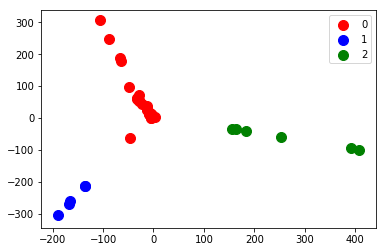

In [499]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(dot[ix, 0], dot[ix, 1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [500]:
ix_0 = np.where(group == 0)
ix_1 = np.where(group == 1)
ix_2 = np.where(group == 2)

In [501]:
ix_0

(array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21,
        22, 23, 24, 26, 27, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43,
        44, 45, 46, 47, 48], dtype=int64),)

In [502]:
ix_1

(array([19, 29, 34, 40, 49], dtype=int64),)

In [503]:
ix_2

(array([ 0,  5,  6, 16, 25, 28], dtype=int64),)

In [512]:
documents[34]

['diminishing',
 'winds',
 'helped',
 'firefighters',
 'battle',
 'acre',
 'brush',
 'fire',
 'steep',
 'rocky',
 'terrain',
 'southern',
 'arizona',
 'monday',
 'montana',
 'fire',
 'crews',
 'returned',
 'home',
 'controlling',
 'acre',
 'grass',
 'fire',
 'killed',
 'cattle',
 'destroyed',
 'three',
 'homes',
 'small',
 'fire',
 'southern',
 'california',
 'angeles',
 'national',
 'forest',
 'may',
 'started',
 'killer',
 'disposing',
 'woman',
 'body',
 'firefighters',
 'elsewhere',
 'forest',
 'monday',
 'evening',
 'contained',
 'acre',
 'brush',
 'fire',
 'may',
 'work',
 'arsonist',
 'southwest',
 'new',
 'mexico',
 'firefighters',
 'struggled',
 'least',
 'five',
 'lightning',
 'caused',
 'wildfires',
 'charred',
 'acres',
 'grassland',
 'trees',
 'authorities',
 'said',
 'largest',
 'fire',
 'burned',
 'least',
 'acres',
 'grass',
 'brush',
 'juniper',
 'trees',
 'pockets',
 'ponderosa',
 'pine',
 'trees',
 'federal',
 'lands',
 'twenty',
 'four',
 'fires',
 'reported',
 'new